In [ ]:
#This code was built with the help from:
#Towards Data Science Website (https://towardsdatascience.com/) and
#Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning (Grasser & Kallumadi)

#The goal was to build a model that can classify drug reviews into 3 rating categories (Negative, Neutral, and Positive)

#The reason why we reduce the rating category set from (1-10) to (-1,0,1) is due to the poor performance 
#that was observed from preliminary models when trying to predict the more comprehensive (1-10) ratings

#The same approach was adopted by (Grasser & Kallumadi)

#Overall test accuracy of the model, after 10-epoch training is __%

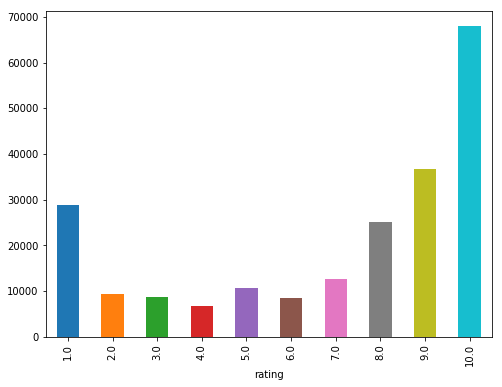

In [19]:
#Importing Python libraries
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

%matplotlib inline

#Loading the train and test drug review data
df = pd.read_csv('drugsComTrain_raw.csv', sep = '\t')
df_t = pd.read_csv('drugsComTest_raw.csv', sep='\t')
df.head(5)

#Combining the files into one large data frame
df = pd.concat([df,df_t])

#Visualizing number of reviews in each rating category
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('rating').review.count().plot.bar(ylim=0)
plt.show()


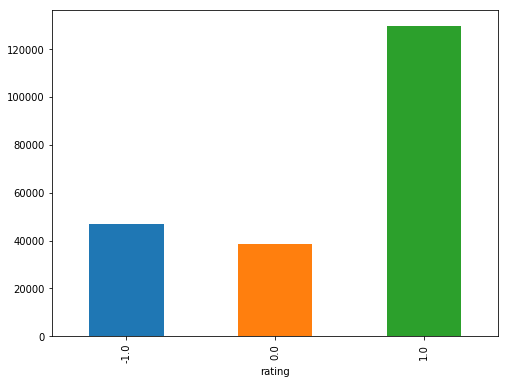

In [20]:
#Placing drug ratings (1-10) into 3 categories: -1 - Negative (1-3), 0 - Neutral (4-7), and +1 - Positive (8-10)
df.loc[df.rating < 4, 'rating'] = int(11)
df.loc[df.rating < 8, 'rating'] = int(12)
df.loc[df.rating < 11, 'rating'] = int(13)

df.loc[df.rating == 11, 'rating'] = int(-1)
df.loc[df.rating == 12, 'rating'] = int(0)
df.loc[df.rating == 13, 'rating'] = int(1)

#Visualizing categorized data
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('rating').review.count().plot.bar(ylim=0)
plt.show()

In [21]:
#Reducing the file size to only review and rating columns
#Removing empty rows
from io import StringIO

col = ['review','rating']
df = df[col]
df = df[pd.notnull(df['review'])]

In [22]:
#Printing an example of a preprocessed review
def print_plot(index):
    example = df[df.index == index][['review', 'rating']].values[0]
    if len(example) > 0:
        print(example[0])
        print('rating:', example[1])

print_plot(10)

from sklearn.model_selection import train_test_split

X = df.review
y = df.rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

"I have been on this medication almost two weeks, started out on 25mg and working my way up to 100mg, currently at 50mg. No headaches at all so far and I was having 2-3 crippling migraines a week. I have lost 5.2lbs so far but note I am really paying close attention to what I am eating, I have a lot of weight to lose and if weight loss is a side effect I want to help it along as much as I can.  Now, other side effects, they are there the word recall issues exist, the memory issues, the worst of it seems to be the vision disturbances, there have been times I have just not driven because I&#039;m sure it would not have been safe. The good news is it seems to be wearing off...I have tons of energy and I am in a great mood."
('rating:', 1.0)


In [23]:
#Cleaning up the review text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
   
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['review'] = df['review'].apply(clean_text)

#Printing an example of a processed review
print_plot(10)
print(df_t['review'].apply(lambda x: len(x.split(' '))).sum())

medication almost two weeks started 25mg working way 100mg currently 50mg headaches far 23 crippling migraines week lost 52lbs far note really paying close attention eating lot weight lose weight loss side effect want help along much side effects word recall issues exist memory issues worst seems vision disturbances times driven i#039 sure would safe good news seems wearing offi tons energy great mood
('rating:', 1.0)
4601711


In [24]:
#Converting review text data into vectors through tokenizing 
#Once each review is represented as a vector it can be used as an input for the Keras model 

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.25, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['review']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['review']), axis=1).values

In [25]:
# Building the model
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .75)
train_reviews = df['review'][:train_size]
train_ratings = df['rating'][:train_size]

test_reviews = df['review'][train_size:]
test_ratings = df['rating'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_reviews) # only fit on train

x_train = tokenize.texts_to_matrix(train_reviews)
x_test = tokenize.texts_to_matrix(test_reviews)

encoder = LabelEncoder()
encoder.fit(train_ratings)
y_train = encoder.fit_transform(train_ratings)
y_test = encoder.fit_transform(test_ratings)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32

#We will only set epochs to 10 (due to the slow processing speed of the laptop) and note that it should be set to ~20
epochs = 10

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 145167 samples, validate on 16130 samples
Epoch 1/10
145167/145167 [==============================] - 93s 642us/step - loss: 0.6937 - acc: 0.7116 - val_loss: 0.6426 - val_acc: 0.7316

In [26]:
#Evaluating the accuracy of the model using the test data
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

53766/53766 [==============================] - 24s 449us/step

In [27]:
#Double checking on 10 random test values
from numpy import argmax
y_pred=model.predict(x_test, batch_size=None, verbose=0, steps=None)
print('Predicted values:\t{}'.format(encoder.inverse_transform(argmax(y_pred[100:110], axis=1) )) )
print('Actual test values:\t{}'.format(encoder.inverse_transform(argmax(y_test[100:110], axis=1) )))

Predicted values:	[ 1.  1.  1.  1. -1.  1. -1.  1.  1.  1.]
Actual test values:	[ 1.  0.  1.  1. -1.  1. -1.  1.  1. -1.]
